![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor


# import

In [75]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
import re
from datetime import datetime

%matplotlib inline
from collections import Counter

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/world-cities-datasets/worldcities.csv
/kaggle/input/sentimentdata/demonetization-tweets.csv
/kaggle/input/sentimentdata/AFINN-111.txt
/kaggle/input/sentimentdata/rt-polarity.pos
/kaggle/input/sentimentdata/rt-polarity.neg
/kaggle/input/world-bank-country-and-lending-groups/worldbank_classification.csv


In [76]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [77]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [78]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [79]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [80]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [81]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [82]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [83]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [84]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [85]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [86]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
35386,id_5387,Barcelona,NaN,5388.0,NaN,3.0,"[['Atypical in a charming area !', 'Great plac...",/Restaurant_Review-g187497-d12353285-Reviews-E...,d12353285,1,4.0
38770,id_8236,London,NaN,8245.0,NaN,4.0,"[['Best place for lunch', 'Great for breakfast...",/Restaurant_Review-g186338-d12019833-Reviews-W...,d12019833,1,5.0
2889,id_2889,London,"['Italian', 'Mediterranean']",9603.0,$$ - $$$,43.0,[['good italian food though the owner and che....,/Restaurant_Review-g186338-d3691706-Reviews-Tr...,d3691706,0,0.0
33652,id_16,Milan,"['Italian', 'Pizza', 'Mediterranean', 'Vegetar...",17.0,$,2800.0,"[['Perfect restaurant', 'Amazing experience!!!...",/Restaurant_Review-g187849-d10229522-Reviews-P...,d10229522,1,4.5
456,id_456,London,"['Fast Food', 'American']",15949.0,$,28.0,[['CHECK ORDER BEFORE LEAVE AS USUALLY SOMETH....,/Restaurant_Review-g186338-d2561843-Reviews-KF...,d2561843,0,0.0


Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [87]:
#заполним пустые значения в Number of Reviews медианным по городу
review_per_city=data[['Number of Reviews','City']].groupby('City').median().round()
dict_review_per_city=review_per_city.reset_index().set_index('City')['Number of Reviews'].to_dict()

def return_review_median(in_city):
    return dict_review_per_city[in_city]


data['review_nums'] =data['City'].apply(return_review_median)
data['Number of Reviews'].fillna(data['review_nums'], inplace=True)
data.drop(['review_nums'], axis=1)


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5
49997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5
49998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0


In [88]:
data['Number of Reviews'].value_counts()

2.0       2403
3.0       2042
4.0       1707
5.0       1471
6.0       1258
          ... 
1932.0       1
1050.0       1
1145.0       1
768.0        1
1087.0       1
Name: Number of Reviews, Length: 1573, dtype: int64

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [89]:
data.nunique(dropna=False)

Restaurant_id        13094
City                    31
Cuisine Style        10732
Ranking              12975
Price Range              4
Number of Reviews     1573
Reviews              41858
URL_TA               49963
ID_TA                49963
sample                   2
Rating                  10
review_nums             22
dtype: int64

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [90]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
# при этом оставим наименование города в нижнем регистре, чтобы потом по нему подтянуть доп признаки 
data['v_city']= data['City'].apply(lambda x:x.lower())
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)


In [91]:
data.head(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,id_0,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
27823,id_2136,['Thai'],2139.0,$,14.0,"[['Delicious affordable Thai dices', 'Poorly a...",/Restaurant_Review-g189852-d6416929-Reviews-Th...,d6416929,1,3.5,...,0,0,0,0,0,1,0,0,0,0
9323,id_9323,"['German', 'Austrian', 'European', 'Central Eu...",102.0,$$ - $$$,444.0,"[['Birthday Dinner - First Night in Vienna', '...",/Restaurant_Review-g190454-d1798840-Reviews-Re...,d1798840,0,0.0,...,0,0,0,0,0,0,1,0,0,0
21076,id_1540,['Thai'],1542.0,NaN,7.0,"[['Delicious satay and massaman', 'Vegetables!...",/Restaurant_Review-g189852-d4472311-Reviews-Ma...,d4472311,1,4.5,...,0,0,0,0,0,1,0,0,0,0
2617,id_2617,"['Italian', 'European', 'Mediterranean', 'Vege...",1195.0,$$ - $$$,112.0,"[['Visiting Hamburg', 'Decent hotel food....']...",/Restaurant_Review-g187331-d2006579-Reviews-Re...,d2006579,0,0.0,...,0,0,0,0,0,0,0,0,0,0
28167,id_2996,NaN,2998.0,NaN,43.0,"[['Really fast service', 'Basic local bar/rest...",/Restaurant_Review-g187514-d991719-Reviews-Asa...,d991719,1,4.0,...,0,0,0,0,0,0,0,0,0,0


#### Возьмем следующий признак "Price Range".

In [93]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3

In [94]:
#заменим значения последовательными числами, пустые значения заменим модой
price_range = {'$$$$': 3, '$$ - $$$': 2, '$': 1}
data['Price Range']=data['Price Range'].apply(lambda x: price_range.get(x))
data['Price Range'].value_counts()

2.0    23041
1.0     7816
3.0     1782
Name: Price Range, dtype: int64

In [95]:
data['Price Range'].fillna(2, inplace=True)
data['Price Range'].value_counts()

2.0    40402
1.0     7816
3.0     1782
Name: Price Range, dtype: int64

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

In [96]:
#добавим дополнительные столбцы с типом кухни 

def find_item(cell):
    if item in cell:
        return 1
    return 0

# если кухня явно не указана, заполним как Other
data['Cuisine Style'].fillna('other', inplace=True)

# создаём пустое множество для хранения уникальных значений кухонь
cuisins = set()
# заполним его на основе значений столбца
for i in data['Cuisine Style']:
    for k in i[1:-1].split(','):
        a = k.replace(' ', '')[1:-1]
        cuisins.add(a)
# на основе этого множества  создаем доп столбцы
for item in cuisins:
    data[item] = data['Cuisine Style'].replace(' ', '').apply(find_item)
# удаляем уже не нужный столбец с типом кухни
# data.drop(['Cuisine Style'], axis=1, inplace=True)

In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 170 entries, Restaurant_id to Mongolian
dtypes: float64(5), int64(127), object(6), uint8(32)
memory usage: 54.2+ MB


In [98]:
#добавим столбец с количеством дней от максимальной даты
def return_date(in_list):
    pattern = r'\d{2}/\d{2}/\d{4}'
    if pd.isna(in_list)==False:
        l = re.findall(pattern, in_list)
        if len(l) != 0:
            return max(list(map(lambda x: datetime.strptime(x, '%m/%d/%Y'), l)))


data['date_val'] =data['Reviews'].apply(return_date)
data['date_max'] = data['date_val'].max()
data['days_ago'] = abs(data['date_max']-data['date_val'])
days_mean = data['days_ago'].mean()

data['days_ago'].fillna(days_mean, inplace=True)
data['days_ago'] = round(data.days_ago.dt.days)

data['days_ago']

0        290
1         83
2         60
3         82
4         18
        ... 
49995     72
49996     67
49997    480
49998    230
49999    757
Name: days_ago, Length: 50000, dtype: int64

Вместе с основными датасэтами соревнований выше подгружены три датасета из общедоступной библиотеки, которые содержат данные о городах,населении в них, градации уровней дохода в разрезе стран, а также датасэт, содержащий анализ настроений. Последний мы будем использовать, чтобы дать положительную или отрицательную оценку отзывам

Выберем необходимую информацию из наших датасетов для использования в дальнейшем:

In [99]:
#В датасете df_cities  сохраним информацию о городах, странах, к которым они относятся, и населении в них
df_cities = pd.read_csv('/kaggle/input/world-cities-datasets/worldcities.csv')
df_cities = df_cities[['city','city_ascii','country','population','capital']]
df_cities[['city','city_ascii','country','capital']]=df_cities[['city','city_ascii','country','capital']].apply(lambda x:x.str.lower())
df_cities.head()

,city,city_ascii,country,population,capital
0,tokyo,tokyo,japan,35676000.0,primary
1,new york,new york,united states,19354922.0,NaN
2,mexico city,mexico city,mexico,19028000.0,primary
3,mumbai,mumbai,india,18978000.0,admin
4,são paulo,sao paulo,brazil,18845000.0,admin


In [100]:
#проверим, если ди дубли по названию города, так как мы будем джойнить по этому полю. так же проверим, что все необходимые города есть в списке,
#и при наличии дубля исключим

df_cities=df_cities[df_cities.capital.isin(['admin','primary'])]
data.loc[data['v_city'] == "oporto",'v_city'] = 'porto'
df_cities=df_cities[df_cities.city_ascii.isin(data['v_city'].tolist())]
duplicate_values=df_cities.groupby('city_ascii').count()

duplicate_values[duplicate_values.city>1]

,city,country,population,capital
city_ascii,,,,
barcelona,2,2,2,2


In [101]:
#основываясь на данных основного датасэта исключим одну страну
df_cities=df_cities[df_cities.country!='venezuela']

In [102]:
df_cities.info()
# df_cities[df_cities['city']=='paris']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 19 to 1036
Data columns (total 5 columns):
city          31 non-null object
city_ascii    31 non-null object
country       31 non-null object
population    31 non-null float64
capital       31 non-null object
dtypes: float64(1), object(4)
memory usage: 1.5+ KB


In [103]:
df_cities.population.fillna(0,inplace=True)
df_cities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 19 to 1036
Data columns (total 5 columns):
city          31 non-null object
city_ascii    31 non-null object
country       31 non-null object
population    31 non-null float64
capital       31 non-null object
dtypes: float64(1), object(4)
memory usage: 1.5+ KB


In [104]:
#В датасете df_country_income сохраним информацию о стране и уровне дохода(грэйде)
df_country_income = pd.read_csv('/kaggle/input/world-bank-country-and-lending-groups/worldbank_classification.csv')
df_country_income.head()

,x,Economy,Code,Region,Income group,Lending category,Other
0,1,Afghanistan,AFG,South Asia,Low income,IDA,HIPC
1,2,Albania,ALB,Europe & Central Asia,Upper middle income,IBRD,NaN
2,3,Algeria,DZA,Middle East & North Africa,Upper middle income,IBRD,NaN
3,4,American Samoa,ASM,East Asia & Pacific,Upper middle income,NaN,NaN
4,5,Andorra,AND,Europe & Central Asia,High income,NaN,NaN


In [105]:
df_country_income = df_country_income[['Economy','Income group']]
df_country_income['Income group'].value_counts()

High income            80
Upper middle income    60
Lower middle income    47
Low income             31
Name: Income group, dtype: int64

In [106]:
#заменим значения последовательными числами
income_range = {'Low income': 0, 'Lower middle income': 1, 'Upper middle income': 2, 'High income': 3}
df_country_income['Income group']=df_country_income['Income group'].apply(lambda x: income_range.get(x))
df_country_income['Economy']=df_country_income['Economy'].apply(lambda x:x.lower())
df_country_income.head()

,Economy,Income group
0,afghanistan,0
1,albania,2
2,algeria,2
3,american samoa,2
4,andorra,3


In [107]:
#Последним обработаем датасет df_cemantic
df_cemantic = pd.read_table('/kaggle/input/sentimentdata/AFINN-111.txt', delim_whitespace=True, names=('word', 'grade'))
df_cemantic['word']=df_cemantic['word'].apply(lambda x:x.lower())
df_cemantic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2477 entries, 0 to 2476
Data columns (total 2 columns):
word     2477 non-null object
grade    2477 non-null object
dtypes: object(2)
memory usage: 38.8+ KB


In [108]:
df_cemantic.grade.value_counts()

-2           962
2            448
-1           309
-3           256
1            208
3            170
4             45
-4            43
-5            16
5              5
up             3
wash           1
direction      1
stand          1
kind           1
in             1
good           1
fun            1
washing        1
working        1
stuff          1
like           1
not            1
Name: grade, dtype: int64

In [109]:
df_cemantic=df_cemantic[df_cemantic.grade.isin(['-5','-4','-3','-2','-1','1','0','1','2','3','4','5'])]
df_cemantic.grade.value_counts()

-2    962
2     448
-1    309
-3    256
1     208
3     170
4      45
-4     43
-5     16
5       5
Name: grade, dtype: int64

In [110]:
dict_semantic=df_cemantic.set_index('word').to_dict()['grade']

def find_grade(in_word):
    i=0
    for key, value in dict_semantic.items():
        if key in in_word:
            i=i+int(value)
    return(i)    

data['Reviews'] = data['Reviews'].apply(lambda x: str(x).lower())
data['semantic_analysis']=0

data['semantic_analysis']=data['Reviews'].apply(find_grade)

In [111]:
data.head()

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,Chilean,NewZealand,Italian,Norwegian,Tunisian,Mongolian,date_val,date_max,days_ago,semantic_analysis
0,id_0,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,0,0,0,0,NaT,2018-02-26,290,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['very good reviews!', 'fine dining in hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,2017-12-05,2018-02-26,83,7
2,id_2,['Vegetarian Friendly'],810.0,2.0,28.0,"[['better than the links', 'ivy black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,2017-12-28,2018-02-26,60,2
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3.0,202.0,"[['most exquisite', 'delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,1,0,0,0,2017-12-06,2018-02-26,82,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3.0,162.0,"[['always the best in bratislava', 'very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,1,0,0,0,2018-02-08,2018-02-26,18,6


In [112]:
#добавим в наш датасет колонку с численностью населения и уровнем дохода
#предварительно заменим в датасете знавение города oporto на porto,
#т.к. предварительный анализ показал, что по этому городу у нас не подтянется численность из-за разности названий

data=data.merge(df_cities, how = 'left', left_on='v_city', right_on='city_ascii')
 

In [113]:
#добавим также значение income
# #предварительно откорректируем для двух стран названия, так как они написаны в коротком формате
data.loc[data['country'] == "slovakia",'country'] = 'slovak republic'
data.loc[data['country'] == "czechia",'country'] = 'czech republic'
 

data=data.merge(df_country_income, how = 'left', left_on='country', right_on='Economy')


In [114]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Columns: 181 entries, Restaurant_id to Income group
dtypes: datetime64[ns](2), float64(6), int64(130), object(11), uint8(32)
memory usage: 58.7+ MB


In [115]:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data[object_columns]
# 

,Restaurant_id,Cuisine Style,Reviews,URL_TA,ID_TA,v_city,city,city_ascii,country,capital,Economy
0,id_0,"['Bar', 'Pub']","[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,paris,paris,paris,france,primary,france
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...","[['very good reviews!', 'fine dining in hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,helsinki,helsinki,helsinki,finland,primary,finland
2,id_2,['Vegetarian Friendly'],"[['better than the links', 'ivy black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,edinburgh,edinburgh,edinburgh,united kingdom,admin,united kingdom
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...","[['most exquisite', 'delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,london,london,london,united kingdom,primary,united kingdom
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...","[['always the best in bratislava', 'very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,bratislava,bratislava,bratislava,slovak republic,primary,slovak republic
...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...","[['the real italian experience!', 'wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,milan,milan,milan,italy,admin,italy
49996,id_6340,"['French', 'American', 'Bar', 'European', 'Veg...","[['parisian atmosphere', 'bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,paris,paris,paris,france,primary,france
49997,id_1649,"['Japanese', 'Sushi']","[['good by swedish standards', 'a hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,stockholm,stockholm,stockholm,sweden,primary,sweden
49998,id_640,"['Polish', 'European', 'Eastern European', 'Ce...","[['underground restaurant', 'oldest restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,warsaw,warsaw,warsaw,poland,primary,poland


In [116]:
#удалим все поля с типом object
data.drop(object_columns, axis = 1, inplace=True)
data.drop(['date_val','date_max'], axis = 1, inplace=True)

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

In [ ]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

1. У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

In [ ]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

In [ ]:
df_train['Ranking'][df_train['City'] =='Paris'].hist(bins=200)

In [ ]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


In [ ]:
TT=df_train
# метод .mean() позволяет вычислить арифметическое среднее значение вектора
# meanRank = TT['Ranking'].mean()

# # Центрирование
# centrRank = TT['Ranking'] - meanRank

# # вычисляем длины векторов для нормирования
# c_normRank = np.linalg.norm(centrRank)

# Нормирование: делим каждый центрированный вектор на его длину
TT['stand_ranking']=centrRank/ c_normRank


In [ ]:
# посмотрим на топ 10 городов
for x in (TT['City'].value_counts())[0:10].index:
    TT['stand_ranking'][TT['City'] == x].hist(bins=100)
plt.show()

### Посмотрим распределение целевой переменной

In [ ]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

In [ ]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

In [ ]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

In [ ]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

# полная матрица корреляций
# используем метод Pandas corr()
# C = bostonDF.corr(method='pearson')
# C

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [118]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
    
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [129]:
def preproc_data(df_input):


    '''includes several functions to pre-process the predictor df_output.'''
   
    
    data = df_input.copy()
    ##############################################################################################################
    #заполним пустые значения в Number of Reviews медианным по городу
    review_per_city=data[['Number of Reviews','City']].groupby('City').median().round()
    dict_review_per_city=review_per_city.reset_index().set_index('City')['Number of Reviews'].to_dict()

    def return_review_median(in_city):
        return dict_review_per_city[in_city]


    data['review_nums'] =data['City'].apply(return_review_median)
    data['Number of Reviews'].fillna(data['review_nums'], inplace=True)
    data.drop(['review_nums'], axis=1)
    ##############################################################################################################
    
    
    
    ##############################################################################################################
    #создадим dummy переменные по городу
    data['v_city']= data['City'].apply(lambda x:x.lower())
    data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)
    ##############################################################################################################
    

    ##############################################################################################################
    # Возьмем следующий признак "Price Range".
    # По описанию 'Price Range' это - Цены в ресторане.  
    # Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3

    #заменим значения последовательными числами, пустые значения заменим модой
    price_range = {'$$$$': 3, '$$ - $$$': 2, '$': 1}
    data['Price Range']=data['Price Range'].apply(lambda x: price_range.get(x))
    data['Price Range'].value_counts()

    data['Price Range'].fillna(2, inplace=True)
    data['Price Range'].value_counts()
    ##############################################################################################################

    
    
    
    ##############################################################################################################
    #добавим дополнительные столбцы с типом кухни 

    def find_item(cell):
        if item in cell:
            return 1
        return 0
    
    # если кухня явно не указана, заполним как Other
    data['Cuisine Style'].fillna('xxotherxx', inplace=True)

    # создаём пустое множество для хранения уникальных значений кухонь
    cuisins = set()
    # заполним его на основе значений столбца
    for i in data['Cuisine Style']:
        for k in i[1:-1].split(","):
            a = k[1:-1].replace("'",'')
            cuisins.add(a)
    # на основе этого множества  создаем доп столбцы
    for item in cuisins:
        data[item] = data['Cuisine Style'].replace(' ', '').apply(find_item)    
    ##############################################################################################################    
   



    ##############################################################################################################
    #добавим столбец с количеством дней от максимальной даты
    def return_date(in_list):
        pattern = r'\d{2}/\d{2}/\d{4}'
        if pd.isna(in_list)==False:
            l = re.findall(pattern, in_list)
            if len(l) != 0:
                return max(list(map(lambda x: datetime.strptime(x, '%m/%d/%Y'), l)))


    data['date_val'] =data['Reviews'].apply(return_date)
    data['date_max'] = data['date_val'].max()
    data['days_ago'] = abs(data['date_max']-data['date_val'])
    days_mean = data['days_ago'].mean()

    data['days_ago'].fillna(days_mean, inplace=True)
    data['days_ago'] = round(data.days_ago.dt.days)

    data['days_ago']
    
    ##############################################################################################################
    # data.info()

    # Вместе с основными датасэтами соревнований выше подгружены три датасета из общедоступной библиотеки, которые содержат данные о городах,населении в них, градации уровней дохода в разрезе стран, а также датасэт, содержащий анализ настроений. Последний мы будем использовать, чтобы дать положительную или отрицательную оценку отзывам

    # Выберем необходимую информацию из наших датасетов для использования в дальнейшем:

    #В датасете df_cities  сохраним информацию о городах, странах, к которым они относятся, и населении в них
    df_cities = pd.read_csv('/kaggle/input/world-cities-datasets/worldcities.csv')
    df_cities = df_cities[['city','city_ascii','country','population','capital']]
    df_cities[['city','city_ascii','country','capital']]=df_cities[['city','city_ascii','country','capital']].apply(lambda x:x.str.lower())
    df_cities.head()

    #проверим, если ди дубли по названию города, так как мы будем джойнить по этому полю. так же проверим, что все необходимые города есть в списке,
    #и при наличии дубля исключим

    df_cities=df_cities[df_cities.capital.isin(['admin','primary'])]
    data.loc[data['v_city'] == "oporto",'v_city'] = 'porto'
    df_cities=df_cities[df_cities.city_ascii.isin(data['v_city'].tolist())]
    duplicate_values=df_cities.groupby('city_ascii').count()

    duplicate_values[duplicate_values.city>1]

    #основываясь на данных основного датасэта исключим одну страну
    df_cities=df_cities[df_cities.country!='venezuela']

    df_cities.info()
    # df_cities[df_cities['city']=='paris']

    df_cities.population.fillna(0,inplace=True)
    df_cities.info()

    ##############################################################################################################
    #В датасете df_country_income сохраним информацию о стране и уровне дохода(грэйде)
    df_country_income = pd.read_csv('/kaggle/input/world-bank-country-and-lending-groups/worldbank_classification.csv')
    df_country_income.head()

    df_country_income = df_country_income[['Economy','Income group']]
    df_country_income['Income group'].value_counts()

    #заменим значения последовательными числами
    income_range = {'Low income': 0, 'Lower middle income': 1, 'Upper middle income': 2, 'High income': 3}
    df_country_income['Income group']=df_country_income['Income group'].apply(lambda x: income_range.get(x))
    df_country_income['Economy']=df_country_income['Economy'].apply(lambda x:x.lower())
    df_country_income.head()

    
    ##############################################################################################################
    #Последним обработаем датасет df_cemantic
    df_cemantic = pd.read_table('/kaggle/input/sentimentdata/AFINN-111.txt', delim_whitespace=True, names=('word', 'grade'))
    df_cemantic['word']=df_cemantic['word'].apply(lambda x:x.lower())
    df_cemantic.info()

    df_cemantic.grade.value_counts()

    df_cemantic=df_cemantic[df_cemantic.grade.isin(['-5','-4','-3','-2','-1','1','0','1','2','3','4','5'])]
    df_cemantic.grade.value_counts()

    dict_semantic=df_cemantic.set_index('word').to_dict()['grade']

    def find_grade(in_word):
        i=0
        for key, value in dict_semantic.items():
            if key in in_word:
                i=i+int(value)
        return(i)    

    data['Reviews'] = data['Reviews'].apply(lambda x: str(x).lower())
    data['semantic_analysis']=0

    data['semantic_analysis']=data['Reviews'].apply(find_grade)

    data.head()
    ##############################################################################################################
    
    
    #добавим в наш датасет колонку с численностью населения и уровнем дохода
    #предварительно заменим в датасете знавение города oporto на porto,
    #т.к. предварительный анализ показал, что по этому городу у нас не подтянется численность из-за разности названий

    data=data.merge(df_cities, how = 'left', left_on='v_city', right_on='city_ascii')


    #добавим также значение income
    # #предварительно откорректируем для двух стран названия, так как они написаны в коротком формате
    data.loc[data['country'] == "slovakia",'country'] = 'slovak republic'
    data.loc[data['country'] == "czechia",'country'] = 'czech republic'


    data=data.merge(df_country_income, how = 'left', left_on='country', right_on='Economy')


    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in data.columns if data[s].dtypes == 'object']
    data.drop(object_columns, axis = 1, inplace=True)
    
    data.drop(['date_val','date_max'], axis = 1, inplace=True)

    
    return data

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [130]:
df_preproc = preproc_data(data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 19 to 1036
Data columns (total 5 columns):
city          31 non-null object
city_ascii    31 non-null object
country       31 non-null object
population    31 non-null float64
capital       31 non-null object
dtypes: float64(1), object(4)
memory usage: 1.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 19 to 1036
Data columns (total 5 columns):
city          31 non-null object
city_ascii    31 non-null object
country       31 non-null object
population    31 non-null float64
capital       31 non-null object
dtypes: float64(1), object(4)
memory usage: 1.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2477 entries, 0 to 2476
Data columns (total 2 columns):
word     2477 non-null object
grade    2477 non-null object
dtypes: object(2)
memory usage: 38.8+ KB


In [131]:
df_preproc.head(25)

,Ranking,Price Range,Number of Reviews,sample,Rating,review_nums,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,...,Italian,Norwegian,South American,Tunisian,Mongolian,Brew Pub,days_ago,semantic_analysis,population,Income group
0,12963.0,2.0,4.0,0,0.0,44.0,0,0,0,0,...,0,0,0,0,0,0,290,0,9904000.0,3
1,106.0,2.0,97.0,0,0.0,21.0,0,0,0,0,...,0,0,0,0,0,0,83,7,1115000.0,3
2,810.0,2.0,28.0,0,0.0,70.0,0,0,0,0,...,0,0,0,0,0,0,60,2,504966.0,3
3,1669.0,3.0,202.0,0,0.0,38.0,0,0,0,0,...,1,0,0,0,0,0,82,0,8567000.0,3
4,37.0,3.0,162.0,0,0.0,10.0,0,0,0,0,...,1,0,0,0,0,0,18,6,423737.0,3
5,5093.0,1.0,24.0,0,0.0,44.0,0,0,0,0,...,0,0,0,0,0,0,172,3,9904000.0,3
6,3704.0,1.0,2.0,0,0.0,31.0,0,0,0,0,...,0,0,0,0,0,0,290,0,2812000.0,3
7,2330.0,2.0,24.0,0,0.0,24.0,0,0,0,0,...,0,0,0,0,0,0,290,0,1679000.0,3
8,771.0,2.0,2.0,0,0.0,21.0,0,0,0,0,...,0,0,0,0,0,0,50,4,1115000.0,3
9,605.0,2.0,13.0,0,0.0,20.0,0,0,0,0,...,1,0,0,0,0,0,86,3,1264000.0,3


In [133]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [134]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [135]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 167), (40000, 167), (40000, 166), (32000, 166), (8000, 166))

# Model 
Сам ML

In [136]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [137]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [138]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [139]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20888874999999996


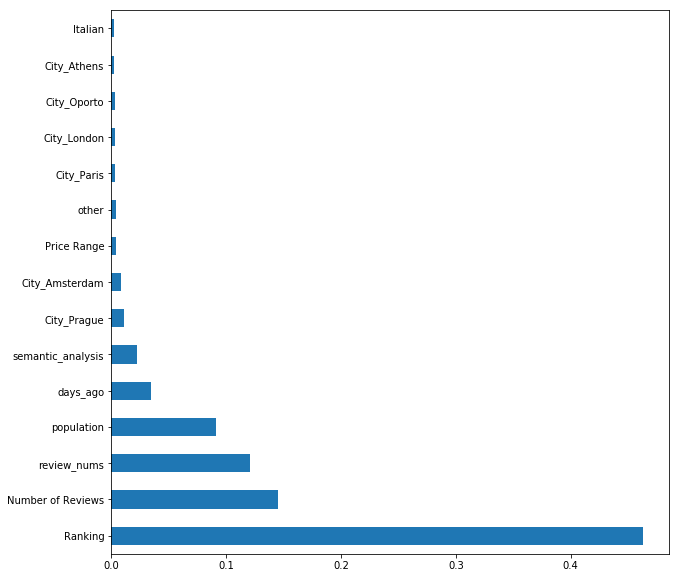

In [140]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [141]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,review_nums,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,...,Italian,Norwegian,South American,Tunisian,Mongolian,Brew Pub,days_ago,semantic_analysis,population,Income group
3441,2018.0,1.0,19.0,0.0,19.0,0,0,0,0,0,...,0,0,0,0,0,0,95,0,1162000.0,3
8145,154.0,1.0,93.0,0.0,28.0,0,0,0,0,0,...,0,0,0,0,0,0,77,3,756000.0,3
377,889.0,2.0,526.0,0.0,29.0,0,0,0,0,0,...,0,0,0,0,0,0,216,3,835000.0,3
6899,810.0,2.0,53.0,0.0,35.0,0,0,1,0,0,...,0,0,0,0,0,1,79,7,4920000.0,3
237,2852.0,2.0,19.0,0.0,119.0,0,0,0,0,0,...,1,0,0,0,0,0,290,0,3339000.0,3
9922,2933.0,1.0,9.0,0.0,46.0,1,0,0,0,0,...,0,0,0,0,0,0,718,3,1031000.0,3
3454,7800.0,2.0,32.0,0.0,27.0,0,0,0,0,0,...,0,0,0,0,0,0,389,6,5567000.0,3
2936,1403.0,2.0,286.0,0.0,47.0,0,0,0,0,0,...,1,0,0,0,0,0,581,13,2945000.0,3
1222,6424.0,2.0,3.0,0.0,35.0,0,0,1,0,0,...,0,0,0,0,0,0,290,0,4920000.0,3
1647,4019.0,2.0,17.0,0.0,17.0,0,0,0,1,0,...,0,0,0,0,0,0,293,1,3406000.0,3


In [142]:
test_data = test_data.drop(['Rating'], axis=1)

In [143]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [144]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [145]:
predict_submission

array([2.995, 4.25 , 4.675, ..., 3.015, 4.49 , 4.48 ])

In [146]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,2.995
1,id_1,4.250
2,id_2,4.675
3,id_3,4.265
4,id_4,4.445
5,id_5,4.465
6,id_6,1.705
7,id_7,2.565
8,id_8,4.345
9,id_9,4.625


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
